In [1]:
# analyse results and determind how many proteins in pdb database have phrog annotations

In [1]:
# imports 
import pandas as pd
import re
from collections import Counter
import requests
import seaborn as sns
import pickle
from itertools import chain
import matplotlib.pyplot as plt

### Look at the lengths of the PHROG representative sequences 

In [2]:
phrog_lengths = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/nonsingleton_representative_sequences.lengths.txt', sep = ' ', header = None)
phrog_lengths[0] = [p[1:] for p in phrog_lengths[0]]

Plot the distributino of the sequence lengths

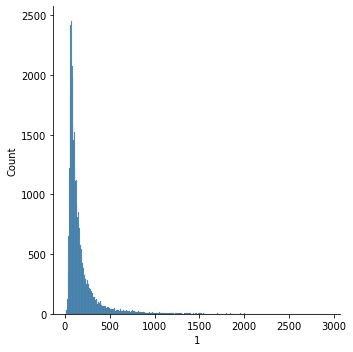

In [3]:
sns.displot(phrog_lengths[1])

### take the proteins clustered with mmseqs instead so that I can see how it works 

In [4]:
mmseqs_phrogs = pd.read_csv('/home/grig0076/scratch/phlegm/all_pdb/mmseqs/results.tsv', sep='\t', header=None)
mmseqs_phrogs.columns = ['phrog', 'pdb_id','alnScore', 'seqIdentity', 'eVal', 'qStart','qEnd','qLen','tStart','tEnd','tLen']
# Compute coverage as (qEnd - qStart + 1) / qLen
mmseqs_phrogs["coverage"] = (mmseqs_phrogs["qEnd"] - mmseqs_phrogs["qStart"] + 1) / mmseqs_phrogs["qLen"]

<ipython-input-5-b067ea1f5e0c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mmseqs_phrogs['coverage']) # use 80% coverage - we want to be strict


<Axes: xlabel='coverage', ylabel='Density'>

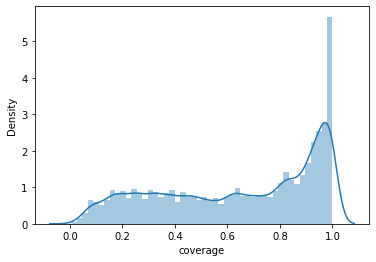

In [5]:
sns.distplot(mmseqs_phrogs['coverage']) # use 80% coverage - we want to be strict 

In [26]:
# I think I should actually rerun the search with all proteins regardless of whether there are multiple phrogs in the complex, can figure this out later 

In [6]:
#mmseqs_phrogs = mmseqs_phrogs[mmseqs_phrogs['coverage'] >= 0.8]
mmseqs_phrogs['pdb'] = [re.split('_', p)[0] for p  in mmseqs_phrogs['pdb_id']] 
mmseqs_phrogs = mmseqs_phrogs.drop_duplicates() # drop duplicates

Read in the states and Deposition Dates obtained with the separate script for this

In [22]:
# read in all the information needing 
#oligomer_predictions = pickle.load(open('/home/grig0076/scratch/phlegm/all_pdb/pharokka/pdb_oligomeric_states.pkl', 'rb'))
oligomer_predictions = pickle.load(open('/home/grig0076/scratch/phlegm/all_pdb/pharokka/pdb_oligomeric_states_mmseqs2.pkl', 'rb')) 

# add deposition date to the dataframe 
date_dict = dict(zip(oligomer_predictions.keys(), [oligomer_predictions.get(i).get('Deposition_Date') for i in list(oligomer_predictions.keys())])) 
mmseqs_phrogs['Deposition_Date'] = [date_dict.get(i) for i in mmseqs_phrogs['pdb']]

In [28]:
# remove pdb heteromers 
keys = list(oligomer_predictions.keys()) 

# need to flag heteromers 
heteromers = [] 

for k in  keys: 
    
    oligomers = set([i[0] for i in list(oligomer_predictions.get(k).get('Assemblies').values())])
    
    if any("Hetero" in s for s in oligomers):
        heteromers.append(k)
        
# remove the heteromers from the dataframe 
mmseqs_phrogs = mmseqs_phrogs[~mmseqs_phrogs['pdb'].isin(heteromers)] 

In [45]:
# get the oligomeric state for the remaining homomers
pdb_phrog_homomers = list(set(mmseqs_phrogs['pdb'])) 
homomeric_state_dict = dict() 

for k in pdb_phrog_homomers: 
    
    assemblies = oligomer_predictions.get(k).get('Assemblies').values()
    assemblies = list(set(list(chain(*assemblies))))
    
    homomeric_state_dict[k] = assemblies

mmseqs_phrogs['oligomeric state'] = [homomeric_state_dict.get(i) for i in mmseqs_phrogs['pdb']]

In [57]:
# For some reason one sequence failed - enter its details manually 
print(mmseqs_phrogs[mmseqs_phrogs['Deposition_Date'] == 'Error'])

entry_8fdz = mmseqs_phrogs.loc[24030]
entry_8fdz['Depsotion_Date'] = '2025-03-25' # I think this structure is just too new probs 

mmseqs_phrogs.loc[24030] = entry_8fdz

            phrog  pdb_id  alnScore  seqIdentity          eVal  qStart  qEnd  \
24030  phrog_9240  8fdz_A       153        0.447  3.461000e-41       1   177   

       qLen  tStart  tEnd  tLen  coverage   pdb Deposition_Date  \
24030   178       2   189   210  0.994382  8fdz           Error   

      oligomeric state  
24030               []  


<ipython-input-57-891fd175d484>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entry_8fdz['Depsotion_Date'] = '2025-03-25' # I think this structure is just too new probs
<ipython-input-57-891fd175d484>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entry_8fdz['Depsotion_Date'] = '2025-03-25' # I think this structure is just too new probs


In [74]:
# filter the results 
# to start with use an eval of -10 and a coverage of 0.8
mmseqs_eval_filter = pd.concat([mmseqs_phrogs[mmseqs_phrogs['eVal'] < 1e-10], mmseqs_phrogs[mmseqs_phrogs['eVal'] ==0 ]])
mmseqs_eval_filter_coverage = mmseqs_eval_filter[mmseqs_eval_filter['coverage'] > 0.8]

In [94]:
# see how many phrogs are represented in the pdb 
# are the oligomeric states conserved across these 


pd.DataFrame.from_dict(Counter(mmseqs_eval_filter_coverage['phrog']), orient = 'index').sort_values(0, ascending=False)
# why does it cap out at 300 - becayuse mmseqs finds up to 300 using the parameters that I used 

,0
phrog_8735,300
phrog_16594,300
phrog_23782,300
phrog_3636,300
phrog_25828,300
...,...
phrog_1004,1
phrog_31561,1
phrog_9906,1
phrog_9064,1


In [97]:
mmseqs_eval_filter_coverage[mmseqs_eval_filter_coverage['phrog'] == p]

# find a nice way of cleaning this up based on the oligomeric state of the proteins 

# then do a brakdown of which types of categories hit the pdb 

,phrog,pdb_id,alnScore,seqIdentity,eVal,qStart,qEnd,qLen,tStart,tEnd,tLen,coverage,pdb,Deposition_Date,oligomeric state
76,phrog_26918,6m3n_A,172,1.000,5.255000e-50,0,66,67,2,68,69,1.000000,6m3n,2020-03-04T00:00:00+0000,[Monomer]
78,phrog_26918,7vzm_A,89,0.676,4.160000e-21,3,66,67,56,119,120,0.955224,7vzm,2021-11-16T00:00:00+0000,[Monomer]
234,phrog_2729,8xkn_V,178,0.424,2.509000e-48,1,236,272,0,228,264,0.867647,8xkn,2023-12-23T00:00:00+0000,[Homo 24-mer]
235,phrog_2729,8ygm_O,178,0.424,2.509000e-48,1,236,272,0,228,264,0.867647,8ygm,2024-02-26T00:00:00+0000,[Homo 18-mer]
236,phrog_2729,8xkn_W,178,0.424,2.509000e-48,1,236,272,0,228,264,0.867647,8xkn,2023-12-23T00:00:00+0000,[Homo 24-mer]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143841,phrog_21327,1qhm_B,1387,1.000,0.000000e+00,1,624,760,0,623,624,0.821053,1qhm,1999-05-19T00:00:00+0000,[Homo 2-mer]
143842,phrog_21327,8id7_A,1256,0.770,0.000000e+00,0,754,760,5,805,810,0.993421,8id7,2023-02-12T00:00:00+0000,[Homo 2-mer]
143843,phrog_21327,8yjn_A,1256,0.770,0.000000e+00,0,754,760,21,821,826,0.993421,8yjn,2024-03-02T00:00:00+0000,[Homo 2-mer]
143844,phrog_21327,6xs4_A,1177,0.728,0.000000e+00,0,754,760,6,806,811,0.993421,6xs4,2020-07-14T00:00:00+0000,[Homo 2-mer]


In [164]:
# then assign phrog anno
mmseqs_eval_filter_coverage['Deposition_Date']

76        2020-03-04T00:00:00+0000
78        2021-11-16T00:00:00+0000
234       2023-12-23T00:00:00+0000
235       2024-02-26T00:00:00+0000
236       2023-12-23T00:00:00+0000
                    ...           
143841    1999-05-19T00:00:00+0000
143842    2023-02-12T00:00:00+0000
143843    2024-03-02T00:00:00+0000
143844    2020-07-14T00:00:00+0000
143845    2020-07-14T00:00:00+0000
Name: Deposition_Date, Length: 36630, dtype: object

In [124]:
import pandas as pd
from collections import Counter

rows = []

phrogs = list(set(mmseqs_eval_filter_coverage['phrog']))

for p in phrogs:
    phrog_df = mmseqs_eval_filter_coverage[mmseqs_eval_filter_coverage['phrog'] == p]
    
    # Extract and flatten
    phrog_df_states = phrog_df['oligomeric state'].to_list()
    phrog_df_states = [item for sublist in phrog_df_states for item in sublist]
    
    # Count and normalize
    state_counts = Counter(phrog_df_states)
    total = sum(state_counts.values())  # Total number of states
    
    # Prepare row data
    state_rates = {state: count / total for state, count in state_counts.items()}
    state_rates['phrog'] = p
    state_rates['total_states'] = total  # Store total count
    
    rows.append(state_rates)
    
    #filter using the date 2021-09-30
    
    

# Create DataFrame and set 'phrog' as the index
phrog_state_df = pd.DataFrame(rows).set_index('phrog')

# Optional: fill NaN with 0
phrog_state_df = phrog_state_df.fillna(0)


In [171]:
import pandas as pd
from collections import Counter

# Convert Deposition_Date to datetime format, replacing errors with NaT
mmseqs_eval_filter_coverage['Deposition_Date'] = pd.to_datetime(mmseqs_eval_filter_coverage['Deposition_Date'], errors='coerce')

# Define the cutoff date with UTC timezone
cutoff_date = pd.Timestamp("2021-09-30", tz="UTC")

rows = []

phrogs = list(set(mmseqs_eval_filter_coverage['phrog']))

for p in phrogs:
    phrog_df = mmseqs_eval_filter_coverage[mmseqs_eval_filter_coverage['phrog'] == p]
    
    # Extract and flatten oligomeric states
    phrog_df_states = phrog_df['oligomeric state'].to_list()
    phrog_df_states = [item for sublist in phrog_df_states for item in sublist]
    
    # Count and normalize
    state_counts = Counter(phrog_df_states)
    total = sum(state_counts.values())  # Total number of states
    
    # Prepare row data
    state_rates = {state: count / total for state, count in state_counts.items()}
    state_rates['phrog'] = p
    state_rates['total_states'] = total  # Store total count
    
    # Check if any valid deposition date in the phrog is before the cutoff date
    valid_dates = phrog_df['Deposition_Date'].dropna()  # Remove invalid dates (NaT)
    state_rates['contains_training_data'] = (valid_dates < cutoff_date).any()
    
    rows.append(state_rates)

# Create DataFrame and set 'phrog' as the index
phrog_state_df = pd.DataFrame(rows).set_index('phrog')

# Optional: fill NaN with 0
phrog_state_df = phrog_state_df.fillna(0)




<ipython-input-171-2b7b7f396a04>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmseqs_eval_filter_coverage['Deposition_Date'] = pd.to_datetime(mmseqs_eval_filter_coverage['Deposition_Date'], errors='coerce')


In [174]:
Counter(phrog_state_df['contains_training_data'])  

# this means that there are at 132 phrogs that weren't trained on alphafold that I can use as a validation set 
# still see that the otheres are the same for consistency
# can start making comparisons with these if they have finished already 

Counter({False: 132, True: 1056})

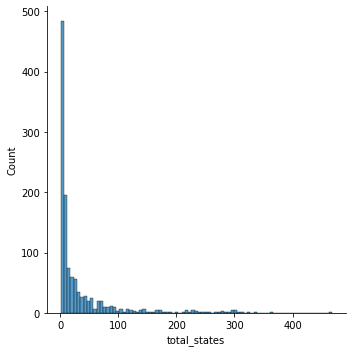

In [129]:
# plot the number of sequences per phrog 
# there actually not that many that overlap
sns.displot(phrog_state_df['total_states']) 


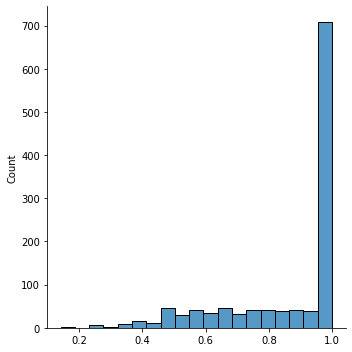

In [122]:
sns.displot(phrog_state_df.max(axis=1))  # can see that most aren't cloudy which is nice 

In [179]:
# add annotations to these 
phrog_annot = pd.read_csv('/home/grig0076/GitHubs/Phynteny_transformer_15012025/Phynteny_transformer/phynteny_utils/phrog_annot_v4.tsv', sep = '\t') 
annot_dict = dict(zip(['phrog_' + str(p) for p in phrog_annot['phrog']], phrog_annot['annot']))
category_dict = dict(zip(['phrog_' + str(p) for p in phrog_annot['phrog']], phrog_annot['category']))

phrog_state_df['phrog_annot'] = [annot_dict.get(p) for p in phrog_state_df.index]
phrog_state_df['phrog_category'] = [category_dict.get(p) for p in phrog_state_df.index]
Counter(phrog_state_df['phrog_category']) # show the mix of the different functions 

In [241]:
# see what the annotations are of our annotated proteins 
phrog_state_posttraining = phrog_state_df[phrog_state_df['contains_training_data'] == False]

max_oligomer = phrog_state_posttraining.drop(['phrog_annot', 'phrog_category', 'total_states', 'contains_training_data'], axis=1).idxmax(axis=1)
max_val = phrog_state_posttraining.drop(['phrog_annot', 'phrog_category', 'total_states', 'contains_training_data'], axis=1).max(axis=1)
posttraining_state = pd.DataFrame({'oligomer': max_oligomer, 'val': max_val})
posttraining_state['category'] = [category_dict.get(p) for p in posttraining_state.index] 
posttraining_state['annot'] = [annot_dict.get(p) for p in posttraining_state.index] 

In [250]:
posttraining_state[posttraining_state['oligomer'] == 'Homo 3-mer']

,oligomer,val,category,annot
phrog,,,,
phrog_4346,Homo 3-mer,1.0,unknown function,NaN
phrog_1727,Homo 3-mer,1.0,tail,tail protein and host specificity
phrog_12132,Homo 3-mer,1.0,unknown function,NaN
phrog_26292,Homo 3-mer,1.0,tail,tail fiber protein
phrog_1833,Homo 3-mer,1.0,tail,tail fiber protein
phrog_16586,Homo 3-mer,1.0,tail,tail fiber protein
phrog_7414,Homo 3-mer,1.0,unknown function,NaN
phrog_19848,Homo 3-mer,1.0,unknown function,NaN
phrog_648,Homo 3-mer,0.6,head and packaging,head scaffolding protein


In [251]:
mmseqs_phrogs[mmseqs_phrogs['phrog'] == 'phrog_1727']

,phrog,pdb_id,alnScore,seqIdentity,eVal,qStart,qEnd,qLen,tStart,tEnd,tLen,coverage,pdb,Deposition_Date,oligomeric state
7166,phrog_1727,8xci_F,580,0.872,3.471000e-186,4,322,327,0,317,1132,0.975535,8xci,2023-12-09T00:00:00+0000,[Homo 3-mer]
7167,phrog_1727,8xci_J,580,0.872,3.471000e-186,4,322,327,0,317,1132,0.975535,8xci,2023-12-09T00:00:00+0000,[Homo 3-mer]
7168,phrog_1727,8xci_Z,580,0.872,3.471000e-186,4,322,327,0,317,1132,0.975535,8xci,2023-12-09T00:00:00+0000,[Homo 3-mer]


In [ ]:
mmseqs_phrogs[mmseqs_phrogs['phrog'] == 'phrog_1004']

In [ ]:
# could potentially even overlay these protein structures over the others 